In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from modAL.models import ActiveLearner
from modAL.models import ActiveLearner
import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline
from scipy import spatial

In [11]:
model("water")

NameError: name 'model' is not defined

In [9]:
original_data = pd.read_csv('../dataset/mohler2_cleaned.csv')
original_data = original_data.drop(labels='Unnamed: 0', axis=1)
original_data = original_data.rename(columns={'question_number':'question_id','question_text':'question','answer_model':'ref_answer','answer_student':'student_answer','score_avg':'grade'})

FileNotFoundError: File b'../dataset/mohler2_cleaned.csv' does not exist

In [4]:
## question Demoting functions

def student_demoting(data):
    return " ".join(x for x in data['student_modified'].split() if x not in data['qn_modified'])

def ref_demoting(data):
    return " ".join(x for x in data['ref_modified'].split() if x not in data['qn_modified'])  


def word_embed(word):
    try:
        vec = model[word]
        vec = vec.reshape(1,vec.shape[0])
    except:
        vec = np.zeros((1, 300))
        #this is hardcoded
    return vec

def model_embed_ref(data):
    sentence  = data ['ref_modified']
    sentence_array = [word_embed(word) for word in sentence.split()]
    return np.sum(sentence_array,axis=0)

def model_embed_stud(data):
    sentence  = data ['stud_modified']
    sentence_array = [word_embed(word) for word in sentence.split()]
    return np.sum(sentence_array,axis=0)

In [12]:
df = original_data.copy()

#converting to lower case
df['qn_modified'] = df['question'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['ref_modified'] = df['ref_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['qn_modified'] = df['qn_modified'].str.replace('[^\w\s]','')
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['qn_modified'] = df['qn_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

##numeric removal
df['qn_modified'] = df['qn_modified'].apply(lambda x: " ".join(word for word in x.split() if not word.isdigit()))
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(word for word in x.split() if not word.isdigit()))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(word for word in x.split() if not word.isdigit()))



#lemmatisation
df['qn_modified'] = df['qn_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

#question demoting
df['student_demoted'] = df.apply(student_demoting,axis=1)
df['ref_demoted'] = df.apply(ref_demoting,axis=1)

#length ratio
df['length_ratio'] = df['student_modified'].apply(lambda x: len(x)) / df['ref_modified'].apply(lambda x: len(x))

#rounding the grades
df['grades_round']= df['grade'].apply(lambda x: round(x))


# #getting the word embeddings
# df['embed_ref'] = df.apply(model_embed_ref,axis = 1)
# df['embed_stud'] = df.apply(model_embed_stud,axis = 1)

df

,question_id,question,ref_answer,student_answer,grade,qn_modified,ref_modified,student_modified,student_demoted,ref_demoted,length_ratio,grades_round
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,role prototype program problem solving,simulate behaviour portion desired software pr...,high risk problem address prototype program ma...,high risk address make sure feasible may also ...,simulate behaviour portion desired software pr...,2.666667,4
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,role prototype program problem solving,simulate behaviour portion desired software pr...,simulate portion desired final product quick e...,simulate portion desired final product quick e...,simulate behaviour portion desired software pr...,2.372549,5
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,role prototype program problem solving,simulate behaviour portion desired software pr...,prototype program simulates behavior portion d...,simulates behavior portion desired software pr...,simulate behaviour portion desired software pr...,1.764706,4
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,role prototype program problem solving,simulate behaviour portion desired software pr...,defined specification phase prototype stimulat...,defined specification phase stimulates behavio...,simulate behaviour portion desired software pr...,3.549020,5
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,role prototype program problem solving,simulate behaviour portion desired software pr...,used let user first idea completed program all...,used let user first idea completed allow clien...,simulate behaviour portion desired software pr...,3.156863,3
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,role prototype program problem solving,simulate behaviour portion desired software pr...,find problem error program finalized,find error finalized,simulate behaviour portion desired software pr...,0.705882,2
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,role prototype program problem solving,simulate behaviour portion desired software pr...,address major issue creation program way accou...,address major issue creation way account possi...,simulate behaviour portion desired software pr...,1.980392,2
7,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,you can break the whole program into prototype...,5.0,role prototype program problem solving,simulate behaviour portion desired software pr...,break whole program prototype program simulate...,break whole simulate part final,simulate behaviour portion desired software pr...,1.274510,5
8,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To provide an example or model of how the fini...,3.5,role prototype program problem solving,simulate behaviour portion desired software pr...,provide example model finished program perfom ...,provide example model finished perfom provides...,simulate behaviour portion desired software pr...,2.882353,4
9,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Simulating the behavior of only a portion of t...,5.0,role prototype program problem solving,simulate behaviour po

In [117]:
# Bag of words creation
CV = CountVectorizer()
bag_of_word_vector = CV.fit_transform(df['student_modified'])
bag_of_word_vector = bag_of_word_vector.toarray()

# Tf-idf creation
Tf = TfidfVectorizer()
tfidf_vector = Tf.fit_transform(df['student_modified'])
tfidf_vector = tfidf_vector.toarray()


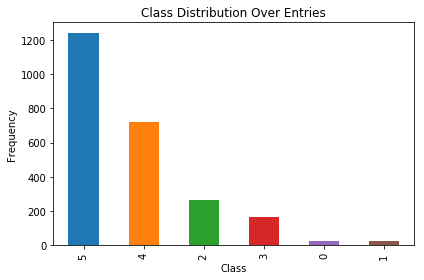

In [118]:
plt.figure()
ax = df['grades_round'].value_counts().plot(kind='bar')

ax.set_title('Class Distribution Over Entries')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [3]:
df = pd.read_pickle("./feature.pkl")  

In [27]:
def cos_similarity(data):
    return 1 - spatial.distance.cosine(data['embed_ref'],data['embed_stud'])
def align_ratio(data):
    return (2*len(data['aligned'])) / (len(data['ref_answer'].split()) + len(data['student_answer'].split()))

In [ ]:
def word_embed(word):
    try:
        vec = model[word]
        vec = vec.reshape(1,vec.shape[0])
    except:
        vec = np.zeros((1, 300))
        #this is hardcoded
    return vec

def model_embed_ref(data):
    sentence  = data ['ref_demoted']
    sentence_array = [word_embed(word) for word in sentence.split()]
    return np.sum(sentence_array,axis=0)

def model_embed_stud(data):
    sentence  = data ['student_demoted']
    sentence_array = [word_embed(word) for word in sentence.split()]
    return np.sum(sentence_array,axis=0)

def cos_similarity_demo(data):
    return 1 - spatial.distance.cosine(data['embed_ref_demoted'],data['embed_stud_demoted'])

def cos_similarity(data):
    return 1 - spatial.distance.cosine(data['embed_ref'],data['embed_stud'])

def align_ratio(data):
    return (2*len(data['aligned'])) / (len(data['ref_answer'].split()) + len(data['student_answer'].split()))

def align_ratio_demo(data):
    if (len(data['ref_demoted'].split()) + len(data['student_demoted'].split())) == 0:
        return 0.0
    else:
        return (2*len(data['aligned_demoted'])) / (len(data['ref_demoted'].split()) + len(data['student_demoted'].split()))

In [5]:
df['cos_similarity']=df.apply(cos_similarity, axis=1)
df['align_ratio']=df.apply(align_ratio, axis=1)

In [6]:
df['len_norm'] = df['length_ratio'].apply(lambda x: x/np.max(df['length_ratio']))

In [7]:
df

,question_id,question,ref_answer,student_answer,grade,qn_modified,ref_modified,student_modified,student_demoted,ref_demoted,length_ratio,grades_round,embed_ref,embed_stud,cos_similarity,len_norm
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,high risk problem are address in the prototype...,high risk are address make sure that feasible ...,simulate behaviour portion desired software pr...,2.764706,4,"[[0.31087402343750004, 0.12618164062500004, 0....","[[-0.34491821289062496, 0.24433044433593754, 1...",0.655149,0.056231
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,to simulate portion of the desired final produ...,simulate portion desired final product with qu...,simulate behaviour portion desired software pr...,2.911765,5,"[[0.31087402343750004, 0.12618164062500004, 0....","[[2.425458984375, 0.7010594177246094, 0.774389...",0.697226,0.059222
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,a prototype program simulates the behavior of ...,simulates behavior portion desired software pr...,simulate behaviour portion desired software pr...,1.661765,4,"[[0.31087402343750004, 0.12618164062500004, 0....","[[-0.10392089843749999, 0.23617462158203129, 0...",0.839926,0.033799
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,defined in the specification phase a prototype...,defined specification phase stimulates behavio...,simulate behaviour portion desired software pr...,3.632353,5,"[[0.31087402343750004, 0.12618164062500004, 0....","[[0.34676391601562506, 0.9747241210937501, 1.0...",0.742990,0.073878
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,it is used to let the user have a first idea o...,it used let user have first idea completed and...,simulate behaviour portion desired software pr...,3.279412,3,"[[0.31087402343750004, 0.12618164062500004, 0....","[[0.5336535644531251, 0.509168930053711, 1.255...",0.724661,0.066700
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,to find problem and error in a program before ...,find and error before it finalized,simulate behaviour portion desired software pr...,0.897059,2,"[[0.31087402343750004, 0.12618164062500004, 0....","[[0.13824584960937503, -0.00038215637207028585...",0.458110,0.018245
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,to address major issue in the creation of the ...,address major issue creation there no way acco...,simulate behaviour portion desired software pr...,2.470588,2,"[[0.31087402343750004, 0.12618164062500004, 0....","[[0.23454956054687504, 0.8501024627685547, 1.3...",0.560865,0.050249
7,1.1,What is the r

In [ ]:
#load word2vec model, here GoogleNews is used
model = gensim.models.KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)
#two sample sentences 
s1 = 'the first sentence'
s2 = 'the second text'

#calculate distance between two sentences using WMD algorithm
distance = model.wmdistance(s1, s2)

print ('distance = %.3f' % distance)

In [124]:
short_df = df[['student_answer','student_modified', 'grade','question' , 'embed_ref','embed_stud' ,'len_norm','cos_similarity']]
short_df['grades_round']= short_df['grade'].apply(lambda x: round(x))

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [125]:
#getting the seed index
classes = short_df['grades_round'].unique()
seed_index = []
for i in classes:
    seed_index.append(short_df['grades_round'][short_df['grades_round']==i].index[0])
# print(type(df['cos_similarity'][0]))
# for i in range(len(df)):
#     if df['len_norm'][i] == NaN:
#         print (i)


In [92]:
np.sum(df['cos_similarity'].isnull().values)

0

In [110]:
CV = CountVectorizer()
student_answer_count_vector = CV.fit_transform(short_df['student_modified'])
student_answer_count_vector = student_answer_count_vector.toarray()

# X = student_answer_count_vector
# X.shape
# Y = short_df['grades_round'].values

(2442, 2231)

In [126]:
#getting the input and output data
# X = short_df['embed_stud'].values
# X = np.concatenate( X, axis=0 ) ## for converting array of array into array
Y = short_df['grades_round'].values
X = np.concatenate((df['len_norm'].values[np.newaxis, :].T,df['cos_similarity'].values[np.newaxis, :].T),axis = 1)

In [127]:
X.shape

(2442, 2)

In [128]:
act_data = short_df.copy()
accuracy_list = []

# initialising
# train_idx = [0, 1, 4 ,5,52,605]
train_idx = seed_index
X_train = X[train_idx]
y_train = Y[train_idx]
# print(y_train)
# generating the pool
X_pool = np.delete(X, train_idx, axis=0)
y_pool = np.delete(Y, train_idx)

act_data = act_data.drop(axis=0,index = train_idx)
act_data.reset_index(drop = True,inplace=True)


# initializing the active learner
lr = LogisticRegression()
# lr = MultinomialNB()
learner = ActiveLearner(
    estimator = lr,
#     estimator = RandomForestClassifier(n_estimators=5),
#     estimator=KNeighborsClassifier(n_neighbors=3),
    X_training=X_train, y_training=y_train
)

# pool-based sampling
n_queries = 40
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool)
    print("\nQ: ", act_data.loc[int(query_idx),'question'])
    print("A: ",act_data.loc[int(query_idx),'student_answer'])
    print("Actual grade: ",y_pool[query_idx].reshape(1, ))
    print ("Class probabilities: ",learner.predict_proba(X_pool[query_idx].reshape(1, -1)))
    human_label = int(input("\nGive me a grade:"))
    learner.teach(
        X=X_pool[query_idx].reshape(1, -1),
        y=[human_label]
    )
    
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx)
    
    act_data = act_data.drop(axis=0,index = query_idx)
    act_data.reset_index(drop=True, inplace=True)
    
    accuracy_list.append(learner.score(X,Y))
    print('Accuracy after query no. %d: %f' % (idx+1, learner.score(X, Y)))


Q:  How many steps does it take to search a node in a binary search tree?
A:  3 steps at most.  There are 3 cases. 
Actual grade:  [2]
Class probabilities:  [[0.16668297 0.16667368 0.16668282 0.16664305 0.16666679 0.16665069]]

Give me a grade:2
Accuracy after query no. 1: 0.109337

Q:  What data structure is more appropriate for scheduling printing jobs at a printer  a stack or a queue?
A:  a queue. 
Actual grade:  [5]
Class probabilities:  [[0.14239934 0.15368006 0.20299274 0.16936583 0.16423266 0.16732938]]

Give me a grade:5
Accuracy after query no. 2: 0.509828

Q:  How are linked lists passed as arguments to a function?
A:  You have to pass the head pointer to a function since it has access to the entire list. 
Actual grade:  [4]
Class probabilities:  [[0.1501323  0.15046786 0.19823648 0.15162358 0.15135058 0.19818921]]

Give me a grade:4
Accuracy after query no. 3: 0.508600

Q:  What is the alternative way to solve a problem that could be solved through recursive functions?
A:  


Give me a grade:5
Accuracy after query no. 28: 0.297707

Q:  What stages in the software life cycle are influenced by the testing stage?
A:  Refining and Coding 
Actual grade:  [5]
Class probabilities:  [[0.07312466 0.09239529 0.25357824 0.07454368 0.25303683 0.2533213 ]]

Give me a grade:5
Accuracy after query no. 29: 0.464373

Q:  What are the elements typically included in a class definition?
A:  return type and input parameters 
Actual grade:  [2]
Class probabilities:  [[0.07452336 0.09273134 0.26020147 0.0744361  0.23765906 0.26044869]]

Give me a grade:2
Accuracy after query no. 30: 0.463964

Q:  What stages in the software life cycle are influenced by the testing stage?
A:  coding and refining 
Actual grade:  [5]
Class probabilities:  [[0.07050941 0.08895561 0.26285859 0.07193448 0.24278952 0.2629524 ]]

Give me a grade:5
Accuracy after query no. 31: 0.508190

Q:  What are the elements typically included in a class definition?
A:  Constructor  functions  and variables native to

In [129]:
from sklearn.model_selection import train_test_split
check_X = np.copy(X)
check_Y = np.copy(Y)

X_train,X_test,Y_train,Y_test = train_test_split(check_X,check_Y,test_size = 0.2)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, Y_train)
score = logisticRegr.score(X_test, Y_test)

print(score)

0.50920245398773


In [130]:
learner.score(X_test,Y_test)

0.4887525562372188

In [13]:
df = pd.read_pickle("./feature.pkl")  
df

,question_id,question,ref_answer,student_answer,grade,qn_modified,ref_modified,student_modified,student_demoted,ref_demoted,length_ratio,grades_round,embed_ref,embed_stud
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,what role prototype program in problem solving,to simulate behaviour portion desired software...,high risk problem address in prototype program...,high risk address make sure that feasible may ...,simulate behaviour portion desired software pr...,3.055556,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.5155224609375, 0.008998413085937518, 1.30..."
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,to simulate portion desired final product quic...,simulate portion desired final product quick a...,simulate behaviour portion desired software pr...,3.074074,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[2.15602783203125, 0.4706297302246094, 0.2766..."
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,prototype program simulates behavior portion d...,simulates behavior portion desired software pr...,simulate behaviour portion desired software pr...,1.722222,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.28229736328125, 0.043576965332031245, 0.2..."
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,defined in specification phase prototype stimu...,defined specification phase stimulates behavio...,simulate behaviour portion desired software pr...,3.814815,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.127725830078125, 0.53630615234375, 0.3706..."
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,it used to let user first idea completed progr...,it used let user first idea completed and allo...,simulate behaviour portion desired software pr...,3.462963,3,"[[0.13071777343750002, -0.10377929687499998, 0...","[[0.23586181640625004, 0.06217674255371097, 0...."
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,to find problem and error in program before it...,find and error before it finalized,simulate behaviour portion desired software pr...,1.037037,2,"[[0.13071777343750002, -0.10377929687499998, 0...","[[0.12119628906250002, 0.0628600311279297, 0.0..."
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,what role prototype program in problem solving,to simulate behaviour portion desired software...,to address major issue in creation program the...,address major issue creation there no way acco...,simulate behaviour portion desired software pr...,2.518519,2,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.10513183593749997, 0.6872704315185547, 0...."
7,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,you can break the whole program into prototype...,5.0,what role prototype program in

In [13]:
sentence1 = df['ref_modified'][0]
sentence2 = df['student_modified'][1]
print(sentence1)

to simulate the behaviour of portion of the desired software product


In [14]:
df.to_pickle("./feature_trial.pkl", protocol=2)

In [15]:
np.random.randn(10)

array([ 1.47180745,  1.41203125,  0.78110225, -0.73916318, -0.47343952,
       -0.69500319,  0.19979711,  1.44240719, -1.35692967,  0.05365978])

In [17]:
len(df)
df['e'] = np.random.randn(len(df))

In [18]:
df

,question_id,question,ref_answer,student_answer,grade,qn_modified,ref_modified,student_modified,student_demoted,ref_demoted,length_ratio,grades_round,embed_ref,embed_stud,e
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,high risk problem are address in the prototype...,high risk are address make sure that feasible ...,simulate behaviour portion desired software pr...,2.764706,4,"[[0.31087402343750004, 0.12618164062500004, 0....","[[-0.34491821289062496, 0.24433044433593754, 1...",1.002981
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,to simulate portion of the desired final produ...,simulate portion desired final product with qu...,simulate behaviour portion desired software pr...,2.911765,5,"[[0.31087402343750004, 0.12618164062500004, 0....","[[2.425458984375, 0.7010594177246094, 0.774389...",0.036798
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,a prototype program simulates the behavior of ...,simulates behavior portion desired software pr...,simulate behaviour portion desired software pr...,1.661765,4,"[[0.31087402343750004, 0.12618164062500004, 0....","[[-0.10392089843749999, 0.23617462158203129, 0...",0.848556
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,defined in the specification phase a prototype...,defined specification phase stimulates behavio...,simulate behaviour portion desired software pr...,3.632353,5,"[[0.31087402343750004, 0.12618164062500004, 0....","[[0.34676391601562506, 0.9747241210937501, 1.0...",-2.269228
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,it is used to let the user have a first idea o...,it used let user have first idea completed and...,simulate behaviour portion desired software pr...,3.279412,3,"[[0.31087402343750004, 0.12618164062500004, 0....","[[0.5336535644531251, 0.509168930053711, 1.255...",1.307041
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,to find problem and error in a program before ...,find and error before it finalized,simulate behaviour portion desired software pr...,0.897059,2,"[[0.31087402343750004, 0.12618164062500004, 0....","[[0.13824584960937503, -0.00038215637207028585...",-0.256376
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,what is the role of a prototype program in pro...,to simulate the behaviour of portion of the de...,to address major issue in the creation of the ...,address major issue creation there no way acco...,simulate behaviour portion desired software pr...,2.470588,2,"[[0.31087402343750004, 0.12618164062500004, 0....","[[0.23454956054687504, 0.8501024627685547, 1.3...",0.240542
7,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d

In [16]:
x = 'my age is 222 '
' '.join(x for x in x.split() if not x.isdigit())

'my age is'

In [19]:
len(df['ref_modified'].unique())

84

In [22]:
df = df.head()

In [25]:
df

,question_id,question,ref_answer,student_answer,grade,qn_modified,ref_modified,student_modified,student_demoted,ref_demoted,length_ratio,grades_round,embed_ref,embed_stud
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,what role prototype program in problem solving,to simulate behaviour portion desired software...,high risk problem address in prototype program...,high risk address make sure that feasible may ...,simulate behaviour portion desired software pr...,3.055556,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.5155224609375, 0.008998413085937518, 1.30..."
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,to simulate portion desired final product quic...,simulate portion desired final product quick a...,simulate behaviour portion desired software pr...,3.074074,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[2.15602783203125, 0.4706297302246094, 0.2766..."
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,prototype program simulates behavior portion d...,simulates behavior portion desired software pr...,simulate behaviour portion desired software pr...,1.722222,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.28229736328125, 0.043576965332031245, 0.2..."
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,defined in specification phase prototype stimu...,defined specification phase stimulates behavio...,simulate behaviour portion desired software pr...,3.814815,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.127725830078125, 0.53630615234375, 0.3706..."
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,it used to let user first idea completed progr...,it used let user first idea completed and allo...,simulate behaviour portion desired software pr...,3.462963,3,"[[0.13071777343750002, -0.10377929687499998, 0...","[[0.23586181640625004, 0.06217674255371097, 0...."


In [4]:
df = pd.read_pickle("./feature_saved.pkl") 
df

,question_id,question,ref_answer,student_answer,grade,qn_modified,ref_modified,student_modified,student_demoted,ref_demoted,length_ratio,grades_round,embed_ref,embed_stud,aligned
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,what role prototype program in problem solving,to simulate behaviour portion desired software...,high risk problem address in prototype program...,high risk address make sure that feasible may ...,simulate behaviour portion desired software pr...,3.055556,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.5155224609375, 0.008998413085937518, 1.30...","[[software, software]]"
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,to simulate portion desired final product quic...,simulate portion desired final product quick a...,simulate behaviour portion desired software pr...,3.074074,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[2.15602783203125, 0.4706297302246094, 0.2766...","[[to, to], [simulate, simulate], [portion, por..."
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,prototype program simulates behavior portion d...,simulates behavior portion desired software pr...,simulate behaviour portion desired software pr...,1.722222,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.28229736328125, 0.043576965332031245, 0.2...","[[portion, portion], [desired, desired], [soft..."
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,defined in specification phase prototype stimu...,defined specification phase stimulates behavio...,simulate behaviour portion desired software pr...,3.814815,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.127725830078125, 0.53630615234375, 0.3706...","[[portion, portion], [desired, desired], [soft..."
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,it used to let user first idea completed progr...,it used let user first idea completed and allo...,simulate behaviour portion desired software pr...,3.462963,3,"[[0.13071777343750002, -0.10377929687499998, 0...","[[0.23586181640625004, 0.06217674255371097, 0....","[[software, software], [product, generate]]"
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,to find problem and error in program before it...,find and error before it finalized,simulate behaviour portion desired software pr...,1.037037,2,"[[0.13071777343750002, -0.10377929687499998, 0...","[[0.12119628906250002, 0.0628600311279297, 0.0...",[]
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,what role prototype program in problem solving,to simulate behaviour portion desired software...,to address major issue in creation program the...,address major issue creation there no way acco...,simulate behaviour portion desired software pr...,2.518519,2,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-

In [5]:
## question Demoting functions

def student_demoting(data):
    return " ".join(x for x in data['student_modified'].split() if x not in data['qn_modified'])

def ref_demoting(data):
    return " ".join(x for x in data['ref_modified'].split() if x not in data['qn_modified'])  

In [6]:


#question demoting
df['student_demoted'] = df.apply(student_demoting,axis=1)
df['ref_demoted'] = df.apply(ref_demoting,axis=1)

In [7]:
##numeric removal
df['ref_demoted'] = df['ref_demoted'].apply(lambda x: " ".join(word for word in x.split() if not word.isdigit()))
df['student_demoted'] = df['student_demoted'].apply(lambda x: " ".join(word for word in x.split() if not word.isdigit()))

In [8]:
df.to_pickle("./feature_trail_demoted.pkl", protocol=2)

In [9]:
df = pd.read_pickle("./feature_trail_demoted.pkl") 

In [10]:
df

,question_id,question,ref_answer,student_answer,grade,qn_modified,ref_modified,student_modified,student_demoted,ref_demoted,length_ratio,grades_round,embed_ref,embed_stud,aligned
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,what role prototype program in problem solving,to simulate behaviour portion desired software...,high risk problem address in prototype program...,high risk address make sure that feasible may ...,simulate behaviour portion desired software pr...,3.055556,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.5155224609375, 0.008998413085937518, 1.30...","[[software, software]]"
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,to simulate portion desired final product quic...,simulate portion desired final product quick a...,simulate behaviour portion desired software pr...,3.074074,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[2.15602783203125, 0.4706297302246094, 0.2766...","[[to, to], [simulate, simulate], [portion, por..."
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,prototype program simulates behavior portion d...,simulates behavior portion desired software pr...,simulate behaviour portion desired software pr...,1.722222,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.28229736328125, 0.043576965332031245, 0.2...","[[portion, portion], [desired, desired], [soft..."
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,defined in specification phase prototype stimu...,defined specification phase stimulates behavio...,simulate behaviour portion desired software pr...,3.814815,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.127725830078125, 0.53630615234375, 0.3706...","[[portion, portion], [desired, desired], [soft..."
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,it used to let user first idea completed progr...,it used let user first idea completed and allo...,simulate behaviour portion desired software pr...,3.462963,3,"[[0.13071777343750002, -0.10377929687499998, 0...","[[0.23586181640625004, 0.06217674255371097, 0....","[[software, software], [product, generate]]"
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,to find problem and error in program before it...,find and error before it finalized,simulate behaviour portion desired software pr...,1.037037,2,"[[0.13071777343750002, -0.10377929687499998, 0...","[[0.12119628906250002, 0.0628600311279297, 0.0...",[]
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,what role prototype program in problem solving,to simulate behaviour portion desired software...,to address major issue in creation program the...,address major issue creation there no way acco...,simulate behaviour portion desired software pr...,2.518519,2,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-

In [11]:
df['cos_similarity']=df.apply(cos_similarity, axis=1)
df['align_ratio']=df.apply(align_ratio, axis=1)

NameError: name 'cos_similarity' is not defined

In [12]:
df

,question_id,question,ref_answer,student_answer,grade,qn_modified,ref_modified,student_modified,student_demoted,ref_demoted,length_ratio,grades_round,embed_ref,embed_stud,aligned
0,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,High risk problems are address in the prototyp...,3.5,what role prototype program in problem solving,to simulate behaviour portion desired software...,high risk problem address in prototype program...,high risk address make sure that feasible may ...,simulate behaviour portion desired software pr...,3.055556,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.5155224609375, 0.008998413085937518, 1.30...","[[software, software]]"
1,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To simulate portions of the desired final prod...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,to simulate portion desired final product quic...,simulate portion desired final product quick a...,simulate behaviour portion desired software pr...,3.074074,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[2.15602783203125, 0.4706297302246094, 0.2766...","[[to, to], [simulate, simulate], [portion, por..."
2,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,A prototype program simulates the behaviors of...,4.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,prototype program simulates behavior portion d...,simulates behavior portion desired software pr...,simulate behaviour portion desired software pr...,1.722222,4,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.28229736328125, 0.043576965332031245, 0.2...","[[portion, portion], [desired, desired], [soft..."
3,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,Defined in the Specification phase a prototype...,5.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,defined in specification phase prototype stimu...,defined specification phase stimulates behavio...,simulate behaviour portion desired software pr...,3.814815,5,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-0.127725830078125, 0.53630615234375, 0.3706...","[[portion, portion], [desired, desired], [soft..."
4,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,It is used to let the users have a first idea ...,3.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,it used to let user first idea completed progr...,it used let user first idea completed and allo...,simulate behaviour portion desired software pr...,3.462963,3,"[[0.13071777343750002, -0.10377929687499998, 0...","[[0.23586181640625004, 0.06217674255371097, 0....","[[software, software], [product, generate]]"
5,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To find problem and errors in a program before...,2.0,what role prototype program in problem solving,to simulate behaviour portion desired software...,to find problem and error in program before it...,find and error before it finalized,simulate behaviour portion desired software pr...,1.037037,2,"[[0.13071777343750002, -0.10377929687499998, 0...","[[0.12119628906250002, 0.0628600311279297, 0.0...",[]
6,1.1,What is the role of a prototype program in pro...,To simulate the behaviour of portions of the d...,To address major issues in the creation of the...,2.5,what role prototype program in problem solving,to simulate behaviour portion desired software...,to address major issue in creation program the...,address major issue creation there no way acco...,simulate behaviour portion desired software pr...,2.518519,2,"[[0.13071777343750002, -0.10377929687499998, 0...","[[-

In [14]:
df['grade'].unique()

array([3.5  , 5.   , 4.   , 3.   , 2.   , 2.5  , 4.5  , 1.5  , 1.   ,
       0.   , 0.5  , 4.125, 3.75 , 1.75 , 2.25 , 3.625, 3.25 , 4.75 ])

In [6]:
df = pd.read_pickle("../../dataset/final_dataset/sem_final_train.pkl")
df

,Unnamed: 0,question,ques_id,reference_answer,student_answer,result,grades_round,student_modified
0,0,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,irrelevant,1,letting sit dish day
1,1,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,4,let water evaporate salt left behind
2,2,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,4,water evaporated left salt crystal
3,3,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,irrelevant,1,saw pinkish grayish color blocking water
4,4,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,irrelevant,1,slowly tip vial water go
5,5,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.","By pouring the water and salt into the thing, ...",correct,4,pouring water salt thing letting water evaporate
6,6,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",By slowly pouring it in a tray.,irrelevant,1,slowly pouring tray
7,7,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",The water evaporated so there was only salt left.,correct,4,water evaporated salt left
8,8,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",We put the water with the salt in it and put i...,correct,4,put water salt put outside water evaporate
9,9,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",I separated the salt from the water because th...,irrelevant,1,separated salt water salt rock bottom water top


In [7]:

## question Demoting functions

def student_demoting(data):
    return " ".join(x for x in data['student_modified'].split() if x not in data['qn_modified'])

def ref_demoting(data):
    return " ".join(x for x in data['ref_modified'].split() if x not in data['qn_modified'])  


#converting to lower case
df['qn_modified'] = df['question'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['ref_modified'] = df['reference_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['student_modified'] = df['student_answer'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#punctuation removal
df['qn_modified'] = df['qn_modified'].str.replace('[^\w\s]','')
df['ref_modified'] = df['ref_modified'].str.replace('[^\w\s]','')
df['student_modified'] = df['student_modified'].str.replace('[^\w\s]','')

#stop word removal
stop = stopwords.words('english')
df['qn_modified'] = df['qn_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# ##numeric removal
# df['qn_modified'] = df['qn_modified'].apply(lambda x: " ".join(word for word in x.split() if not word.isdigit()))
# df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join(word for word in x.split() if not word.isdigit()))
# df['student_modified'] = df['student_modified'].apply(lambda x: " ".join(word for word in x.split() if not word.isdigit()))

#lemmatisation
df['qn_modified'] = df['qn_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['ref_modified'] = df['ref_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))
df['student_modified'] = df['student_modified'].apply(lambda x: " ".join([Word(word).lemmatize() for word in word_tokenize(x)]))

#question demoting
df['student_demoted'] = df.apply(student_demoting,axis=1)
df['ref_demoted'] = df.apply(ref_demoting,axis=1)

#length ratio
df['length_ratio'] = df['student_modified'].apply(lambda x: len(x)) / df['ref_modified'].apply(lambda x: len(x))




In [8]:
df

,Unnamed: 0,question,ques_id,reference_answer,student_answer,result,grades_round,student_modified,qn_modified,ref_modified,student_demoted,ref_demoted,length_ratio
0,0,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,irrelevant,1,letting sit dish day,used several method separate identify substanc...,water evaporated leaving salt,letting sit dish day,evaporated leaving,0.689655
1,1,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,4,let water evaporate salt left behind,used several method separate identify substanc...,water evaporated leaving salt,let evaporate left behind,evaporated leaving,1.241379
2,2,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,4,water evaporated left salt crystal,used several method separate identify substanc...,water evaporated leaving salt,evaporated left crystal,evaporated leaving,1.172414
3,3,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,irrelevant,1,saw pinkish grayish color blocking water,used several method separate identify substanc...,water evaporated leaving salt,saw pinkish grayish color blocking,evaporated leaving,1.379310
4,4,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,irrelevant,1,slowly tip vial water go,used several method separate identify substanc...,water evaporated leaving salt,slowly tip vial go,evaporated leaving,0.827586
5,5,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.","By pouring the water and salt into the thing, ...",correct,4,pouring water salt thing letting water evaporate,used several method separate identify substanc...,water evaporated leaving salt,pouring thing letting evaporate,evaporated leaving,1.655172
6,6,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",By slowly pouring it in a tray.,irrelevant,1,slowly pouring tray,used several method separate identify substanc...,water evaporated leaving salt,slowly pouring tray,evaporated leaving,0.655172
7,7,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",The water evaporated so there was only salt left.,correct,4,water evaporated salt left,used several method separate identify substanc...,water evaporated leaving salt,evaporated left,evaporated leaving,0.896552
8,8,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",We put the water with the salt in it and put i...,correct,4,put water salt put outside water evaporate,used several method separate identify substanc...,water evaporated leaving salt,put put outside evaporate,evaporated leaving,1.448276
9,9,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",I separated the salt from the water because th...,irrelevant,1,separated salt water salt rock bottom water top,used several method separate identify substanc...,water evaporated leaving salt,separated bottom top,evaporated leaving,1.620690


In [15]:

df = pd.read_pickle("../../../../../sem_eval_test3_cosine.pkl")
df.to_pickle("../../../../../sem_eval_test3_cosine.pkl",protocol=2)


# semeval cleaning

In [109]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_pickle("../../../../../sem_eval_test3_aligned.pkl")
# df = pd.read_pickle("../../dataset/sultan_features.pkl")

In [110]:
df

,Unnamed: 0,question,ques_id,reference_answer,student_answer,result,grades_round,student_modified,qn_modified,ref_modified,student_demoted,ref_demoted,length_ratio,embed_ref,embed_stud,embed_ref_demoted,embed_stud_demoted,aligned,aligned_demoted
0,0,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I know the paperclip would scratch it because ...,correct,4,know paperclip would scratch paperclip harder ...,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,harder,harder,0.680000,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[-0.36083984, -0.67645264, -0.16320801, 1.415...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[paperclip, paperclip], [harder, harder], [pe...","[[paperclip, paperclip], [harder, harder], [pe..."
1,1,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I knew that because the paperclip is harder th...,correct,4,knew paperclip harder penny,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,knew harder,harder,0.360000,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[-0.2680664, -0.4666748, -0.23742676, 0.88745...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.0859375, -0.17443848, -0.084472656, 0.3327...","[[paperclip, paperclip], [harder, harder], [pe...","[[paperclip, paperclip], [harder, harder], [pe..."
2,2,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I know that the paperclip would scratch the mi...,correct,4,know paperclip would scratch mineral paperclip...,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,harder,harder,0.786667,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[-0.34973145, -0.744812, -0.045043945, 1.4936...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[scratch, scratch], [mineral, mineral], [pape...","[[scratch, scratch], [mineral, mineral], [pape..."
3,3,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",Because the paperclip is an easier item to scr...,irrelevant,1,paperclip easier item scratch rock mineral penny,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,easier item rock,harder,0.640000,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[-0.20507812, -0.39434814, -0.2006836, 1.3745...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.17077637, -0.041137695, -0.24694824, 0.564...","[[scratch, scratch], [mineral, mineral], [penn...","[[scratch, scratch], [mineral, mineral], [penn..."
4,4,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I know that a paperclip will scratch it becaus...,correct,4,know paperclip scratch hardest tool used finge...,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,hardest,harder,0.893333,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[0.28063965, -0.48309326, 0.258667, 0.8878174...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.30273438, -0.17285156, 0.114746094, 0.1240...","[[penny, penny], [paperclip, paperclip], [scra...","[[penny, penny], [paperclip, paperclip], [scra..."
5,5,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I know because the paperclip is a harder tool ...,correct,4,know paperclip harder tool softer tool scratch...,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,harder softer,harder,0.746667,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[0.46118164, -0.83148193, -0.4008789, 1.00659...","[[0.111328

In [111]:
def cos_similarity(data):
    return 1 - spatial.distance.cosine(data['embed_ref'],data['embed_stud'])

def cos_similarity_demoted(data):
    return 1 - spatial.distance.cosine(data['embed_ref_demoted'],data['embed_stud_demoted'])

def align_ratio(data):
    return (2*len(data['aligned'])) / (len(data['ref_modified'].split()) + len(data['student_modified'].split()))

def align_ratio_demoted(data):
    if (len(data['ref_demoted'].split()) + len(data['student_demoted'].split())) == 0:
        return 0.0
    else:
        return (2*len(data['aligned_demoted'])) / (len(data['ref_demoted'].split()) + len(data['student_demoted'].split()))


df['cos_similarity']=df.apply(cos_similarity, axis=1)
df['cos_similarity_demoted']=df.apply(cos_similarity_demoted, axis=1)
df['align_ratio']=df.apply(align_ratio, axis=1)
df['align_ratio_demoted']=df.apply(align_ratio_demoted, axis=1)


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [112]:
df
# after this replacce NAN with zero and save it as pickle

,Unnamed: 0,question,ques_id,reference_answer,student_answer,result,grades_round,student_modified,qn_modified,ref_modified,...,embed_ref,embed_stud,embed_ref_demoted,embed_stud_demoted,aligned,aligned_demoted,cos_similarity,cos_similarity_demoted,align_ratio,align_ratio_demoted
0,0,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I know the paperclip would scratch it because ...,correct,4,know paperclip would scratch paperclip harder ...,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,...,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[-0.36083984, -0.67645264, -0.16320801, 1.415...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[paperclip, paperclip], [harder, harder], [pe...","[[paperclip, paperclip], [harder, harder], [pe...",0.845901,1.000000,0.588235,5.000000
1,1,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I knew that because the paperclip is harder th...,correct,4,knew paperclip harder penny,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,...,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[-0.2680664, -0.4666748, -0.23742676, 0.88745...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.0859375, -0.17443848, -0.084472656, 0.3327...","[[paperclip, paperclip], [harder, harder], [pe...","[[paperclip, paperclip], [harder, harder], [pe...",0.764915,0.830776,0.428571,2.000000
2,2,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I know that the paperclip would scratch the mi...,correct,4,know paperclip would scratch mineral paperclip...,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,...,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[-0.34973145, -0.744812, -0.045043945, 1.4936...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[scratch, scratch], [mineral, mineral], [pape...","[[scratch, scratch], [mineral, mineral], [pape...",0.937149,1.000000,0.666667,6.000000
3,3,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",Because the paperclip is an easier item to scr...,irrelevant,1,paperclip easier item scratch rock mineral penny,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,...,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[-0.20507812, -0.39434814, -0.2006836, 1.3745...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.17077637, -0.041137695, -0.24694824, 0.564...","[[scratch, scratch], [mineral, mineral], [penn...","[[scratch, scratch], [mineral, mineral], [penn...",0.929984,0.516406,0.470588,2.000000
4,4,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I know that a paperclip will scratch it becaus...,correct,4,know paperclip scratch hardest tool used finge...,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,...,"[[-0.58691406, -0.8526001, -0.08682251, 1.9167...","[[0.28063965, -0.48309326, 0.258667, 0.8878174...","[[0.111328125, -0.15820312, -0.17285156, 0.289...","[[0.30273438, -0.17285156, 0.114746094, 0.1240...","[[penny, penny], [paperclip, paperclip], [scra...","[[penny, penny], [paperclip, paperclip], [scra...",0.790114,0.512123,0.526316,5.000000
5,5,You used 3 scratch tools in class to test mine...,EM_33b,"A paperclip is harder than a penny, so if a pe...",I know because the paperclip is a harder tool ...,correct,4,know paperclip harder tool softer tool scratch...,used 3 scratch tool class test mineral hardnes...,paperclip harder penny penny scratch mineral p...,...,"[[-0.58691406, -0.8526001, -0.08682251

In [106]:
df.columns

Index(['Unnamed: 0', 'question', 'ques_id', 'reference_answer',
       'student_answer', 'result', 'grades_round', 'student_modified',
       'qn_modified', 'ref_modified', 'student_demoted', 'ref_demoted',
       'length_ratio', 'embed_ref', 'embed_stud', 'embed_ref_demoted',
       'embed_stud_demoted', 'aligned', 'aligned_demoted', 'cos_similarity',
       'cos_similarity_demoted', 'align_ratio', 'align_ratio_demoted'],
      dtype='object')

In [67]:
df.fillna(-1, inplace=True)
mms = MinMaxScaler()
df[['length_ratio', 'align_ratio', 'align_ratio_demoted', 'cos_similarity', 'cos_similarity_demoted']] = \
mms.fit_transform(df[['length_ratio', 'align_ratio', 'align_ratio_demoted','cos_similarity', 'cos_similarity_demoted']])
df

,Unnamed: 0,question,ques_id,reference_answer,student_answer,result,grades_round,student_modified,qn_modified,ref_modified,...,embed_ref,embed_stud,embed_ref_demoted,embed_stud_demoted,aligned,aligned_demoted,cos_similarity,cos_similarity_demoted,align_ratio,align_ratio_demoted
0,0,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,irrelevant,1,letting sit dish day,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[-0.22460938, 0.27416992, 0.7092285, 0.818847...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[-0.22460938, 0.27416992, 0.7092285, 0.818847...","[[leaving, letting]]","[[leaving, letting]]",0.658378,0.621936,0.250000,0.033333
1,1,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,4,let water evaporate salt left behind,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[0.3564453, 0.6051636, 0.56933594, 0.1496582,...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.56518555, 0.24578857, 0.24853516, 0.281738...","[[evaporated, evaporate], [water, water], [sal...","[[evaporated, evaporate], [water, water], [sal...",0.923167,0.840224,0.800000,0.133333
2,2,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,4,water evaporated left salt crystal,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[0.19091797, 0.20996094, 0.42590332, -0.26078...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.3996582, -0.14941406, 0.10510254, -0.12870...","[[water, water], [evaporated, evaporated], [sa...","[[water, water], [evaporated, evaporated], [sa...",0.941992,0.857312,0.888889,0.160000
3,3,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,irrelevant,1,saw pinkish grayish color blocking water,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[0.27304077, 0.9921875, 0.0949707, -0.2550048...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.42440796, 0.85546875, -0.021728516, -0.076...","[[water, water]]","[[water, water]]",0.718420,0.608382,0.200000,0.028571
4,4,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,irrelevant,1,slowly tip vial water go,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[-0.037597656, 0.48266602, 0.41375732, -0.120...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.11376953, 0.34594727, 0.2970581, 0.0585937...","[[water, water], [leaving, go]]","[[water, water], [leaving, go]]",0.744652,0.616578,0.444444,0.066667
5,5,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.","By pouring the water and salt into the thing, ...",correct,4,pouring water salt thing letting water evaporate,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[0.09765625, 1.1340332, 0.47265625, 0.1145019...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.45776367, 0.63793945, 0.03515625, 0.425292...","[[leaving, letting], [water, water], [salt, sa...","[[leaving, letting], [water, water], [salt, sa...",0.910201,0.784838,0.727273,0.133333
6,6,You used several methods to separate and ident...,EM_45b,"The water was evaporat

In [113]:
df.fillna(-1, inplace=True)
df[['cos_similarity', 'cos_similarity_demoted']] = df[['cos_similarity', 'cos_similarity_demoted']].apply(lambda x:x+1)

In [114]:
df.to_pickle("../../dataset/final_dataset/sem_eval_test3.pkl")

In [79]:
print (np.sum(df['cos_similarity']<0))
print (np.sum(df['cos_similarity'].isnull()))
print (np.sum(df['cos_similarity_demo']<0))
print (np.sum(df['cos_similarity_demo'].isnull()))

0
0
0
0


In [6]:
df.dropna(inplace=True)

In [7]:
df

,Unnamed: 0,question,ques_id,reference_answer,student_answer,result,grades_round,student_modified,qn_modified,ref_modified,...,embed_ref,embed_stud,embed_ref_demoted,embed_stud_demoted,aligned,aligned_demoted,cos_similarity,cos_similarity_demoted,align_ratio,align_ratio_demoted
0,0,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,irrelevant,1,letting sit dish day,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[-0.22460938, 0.27416992, 0.7092285, 0.818847...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[-0.22460938, 0.27416992, 0.7092285, 0.818847...","[[leaving, letting]]","[[leaving, letting]]",0.316756,0.243872,0.250000,0.333333
1,1,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,4,let water evaporate salt left behind,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[0.3564453, 0.6051636, 0.56933594, 0.1496582,...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.56518555, 0.24578857, 0.24853516, 0.281738...","[[evaporated, evaporate], [water, water], [sal...","[[evaporated, evaporate], [water, water], [sal...",0.846334,0.680449,0.800000,1.333333
2,2,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,4,water evaporated left salt crystal,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[0.19091797, 0.20996094, 0.42590332, -0.26078...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.3996582, -0.14941406, 0.10510254, -0.12870...","[[water, water], [evaporated, evaporated], [sa...","[[water, water], [evaporated, evaporated], [sa...",0.883985,0.714624,0.888889,1.600000
3,3,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,irrelevant,1,saw pinkish grayish color blocking water,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[0.27304077, 0.9921875, 0.0949707, -0.2550048...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.42440796, 0.85546875, -0.021728516, -0.076...","[[water, water]]","[[water, water]]",0.436839,0.216765,0.200000,0.285714
4,4,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,irrelevant,1,slowly tip vial water go,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[-0.037597656, 0.48266602, 0.41375732, -0.120...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.11376953, 0.34594727, 0.2970581, 0.0585937...","[[water, water], [leaving, go]]","[[water, water], [leaving, go]]",0.489303,0.233156,0.444444,0.666667
5,5,You used several methods to separate and ident...,EM_45b,"The water was evaporated, leaving the salt.","By pouring the water and salt into the thing, ...",correct,4,pouring water salt thing letting water evaporate,used several method separate identify substanc...,water evaporated leaving salt,...,"[[0.06713867, 0.51220703, 0.32043457, -0.32836...","[[0.09765625, 1.1340332, 0.47265625, 0.1145019...","[[0.2758789, 0.15283203, -0.00036621094, -0.19...","[[0.45776367, 0.63793945, 0.03515625, 0.425292...","[[leaving, letting], [water, water], [salt, sa...","[[leaving, letting], [water, water], [salt, sa...",0.820402,0.569675,0.727273,1.333333
6,6,You used several methods to separate and ident...,EM_45b,"The water was evaporat